In [135]:
import joblib
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt

In [136]:
X_COLUMNS = ['year', 'month', 'date', 'rain', 'precip', 'mean_temp', 'snow_on_grnd', 'snow_precip']
OUTPUT_COLUMNS = ['date','year', 'month', 'rain', 'precip', 'mean_temp', 'snow_on_grnd', 'snow_precip']

station_data = pd.read_csv('./index_data/closest_weather_to_hydro_stations.csv')
rename_map = { station_data.columns[0]: 'hydro_id',
              'Latitude (Decimal Degrees)': 'latitude',
              'Longitude (Decimal Degrees)': 'longitude',
              'Name': 'weather_name',
              'Climate ID': 'weather_climate_id',
              'Station ID': 'weather_station_id',
              'First Year': 'weather_first_year',
              'Last Year': 'weather_last_year',
              'Elevation (m)': 'weather_elevation(m)', # in m
              'First Year': 'weather_first_year',
              'Last Year': 'weather_last_year',
             }
station_data.rename(columns=rename_map, inplace=True)

mean_data, stdev_data = None, None

In [137]:
def load_model(hydro_id):
     return joblib.load('./models/model-hydro_{hydro_id}.pckl'.format(hydro_id=hydro_id))


def get_weather_cluster_data(hydro_id):
    weather_station_id = station_data[station_data['hydro_id'] == hydro_id]['weather_station_id'].values[0]
   
    mean_data = pd.read_csv('./cluster_data/{}-daily.csv'.format(weather_station_id))
    stdev_data = pd.read_csv('./cluster_data/{}-stdev.csv'.format(weather_station_id))
    
    return mean_data, stdev_data


def filter_df(df, month, day):
    return df[(df['month'] == month) & (df['day']==day)]


def genday(month, day, cluster_id):
    generate_cols = ['rain', 'precip', 'mean_temp', 'snow_on_grnd', 'snow_precip']

    means = filter_df(mean_data, month, day)
    means= means[means['cluster_id'] == cluster_id][generate_cols]
    stds = filter_df(stdev_data, month, day)[generate_cols]
    
    return np.random.normal(loc=means,scale=stds)[0]

def generate_weather_data(df_row, cluster_id):
    row = genday(df_row['month'], df_row['day'], cluster_id)
    
    # make sure values can't be negative, except for temp
    return pd.Series([abs(val) if enum !=3 else val for enum, val in enumerate(row)])

def generate_regression_input(start_year, start_month, start_day, days, cluster_id):
    start_date = '{year}-{month}-{date}'.format(year=start_year, month=start_month, date=start_day)
    df = pd.DataFrame({'Date/Time':pd.date_range(start=start_date, periods=days)}).set_index('Date/Time')
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['date'] = df.index.map(dt.datetime.toordinal)
    
    generated_data = df.apply(generate_weather_data, cluster_id=cluster_id, axis=1)
    
    regression_input = df.join(generated_data)
    del regression_input['day']
    regression_input.columns = X_COLUMNS
    
    return regression_input[OUTPUT_COLUMNS]

In [140]:
def filter_by_date_range(df,start,end):
    # start, end format %Y-%m-%d
    df = df.reset_index(drop=False)
    df = df.rename(columns={'index':'Date/Time'})
    df['Date/Time'] = pd.to_datetime(df['Date/Time'],format="%Y-%m-%d",errors='coerce')
    df = df[pd.notnull(df['Date/Time'])]

    df = df[(df['Date/Time'] <= end) &(df['Date/Time'] >= start)]
    
    return df.set_index('Date/Time')

def plot_model(regression_data, real_data, model, output_filename, cluster_id):
    # real values in blue, predicted values in red
    
    plt.xlabel('Date')
    plt.ylabel('Water Levels (cm)')
    plt.plot(real_data['water_level'], 'b.', alpha=0.5)
    
    plt.plot(regression_data['date'], model.predict(regression_data[OUTPUT_COLUMNS]), 'r.', alpha=0.7)
    plt.savefig('models/cluster_predict{}.png'.format(output_filename))

In [139]:
daily_keys = ['hydro_07ED002',
 'hydro_08EB003',
 'hydro_08EC001',
 'hydro_08GA030',
 'hydro_08GA077',
 'hydro_08GA079',
 'hydro_08GB013',
 'hydro_08HA009',
 'hydro_08HB082',
 'hydro_08HC006',
 'hydro_08HD025',
 'hydro_08JA023',
 'hydro_08LC041',
 'hydro_08MH141',
 'hydro_08MH148',
 'hydro_08MH149',
 'hydro_08MH167',
 'hydro_08NA002',
 'hydro_08NB017',
 'hydro_08ND017',
 'hydro_08NE102',
 'hydro_08NE103',
 'hydro_08NE104',
 'hydro_08NE126',
 'hydro_08NH064',
 'hydro_08NH127',
 'hydro_08NM202',
 'hydro_08NM212',
 'hydro_08NM213',
 'hydro_08NM234']

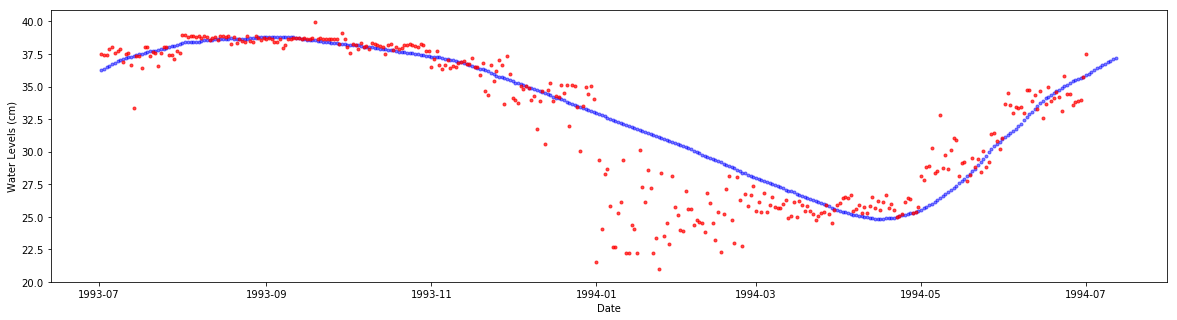

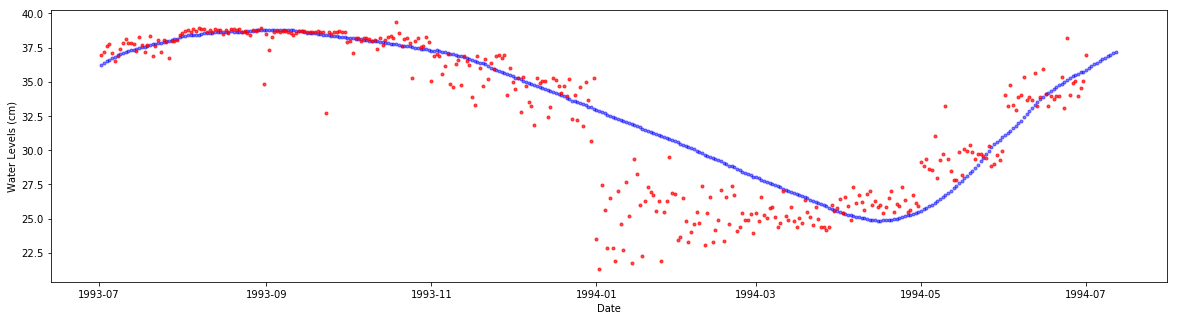

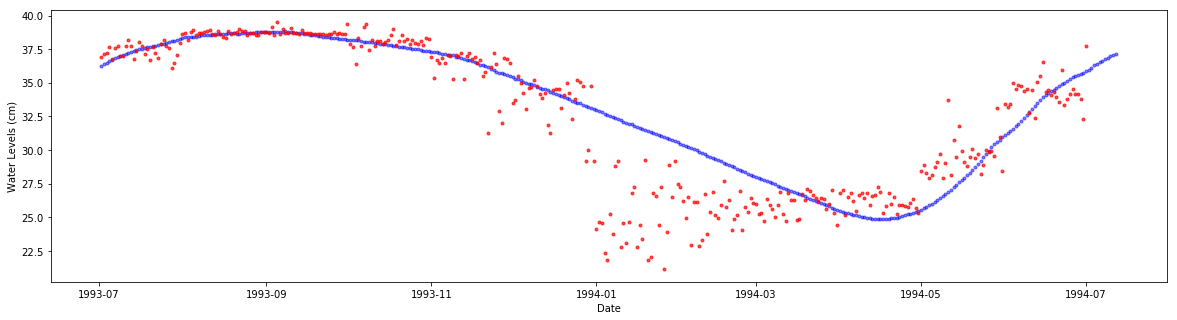

In [142]:
# to generate something here, the appropriate model should have been created in 'daily_models.ipynb'
# in that notebook, call `create_models(key)` with the appropriate key to generate the model over here
# the key should have format hydro_xxxxxxx
hydro_id = 'hydro_07ED002'[6:] # choose this from daily_keys
real_data = pd.read_hdf('daily_combined_data.hdf', key='hydro_{}'.format(hydro_id)).sort_index().dropna()
# choose a date range, match it in line 8
real_data = filter_by_date_range(real_data, '1993-07-02', '1994-07-12') 
model = load_model(hydro_id)
mean_data, stdev_data = get_weather_cluster_data(hydro_id)

for cluster_id in range(3):
    regression_input = generate_regression_input(start_year=1993, start_month=7, start_day=2, cluster_id=cluster_id, days=365)
    plt.figure(figsize=(20,5))
    plot_model(regression_input, real_data, model, '{0}_{1}'.format(hydro_id, cluster_id), cluster_id)
    plt.show()